In [733]:
%matplotlib inline

# for plotting images + graphs
import matplotlib.pyplot as plt

# OpenCV for reading image files from disk + converting color formats
import cv2
import os

In [734]:
healthy_path = '../data/raw/healthy_eye'
infected_path = '../data/raw/infected_eye'

In [735]:
# lists all the files in each folder
# slices the first five

healthy_imgs = os.listdir(healthy_path)[:5]
infected_imgs = os.listdir(infected_path)[:5]

print("Healthy files: ", healthy_imgs)
print("Infected files: ", infected_imgs)


Healthy files:  ['63.jpg', '77.jpg', '162.jpg', '88.jpg', '172.jpeg']
Infected files:  ['63.jpg', '77.jpg', '176.jpg', '88.jpg', '172.jpeg']


In [736]:
# relative path (up one level from root)
processed_healthy_path = '../data/processed/healthy_eye'
processed_infected_path = '../data/processed/infected_eye'

# make processed folders if they don’t exist
# exist_ok = True -> if folder exists don't throw error
os.makedirs(processed_healthy_path, exist_ok=True)
os.makedirs(processed_infected_path, exist_ok=True)

In [737]:
def load_image_convert(img_path):

    # loads image
    img = cv2.imread(img_path)

    # opencv reads in bgr, but matplotlib needs rgb
    # so converts colors
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

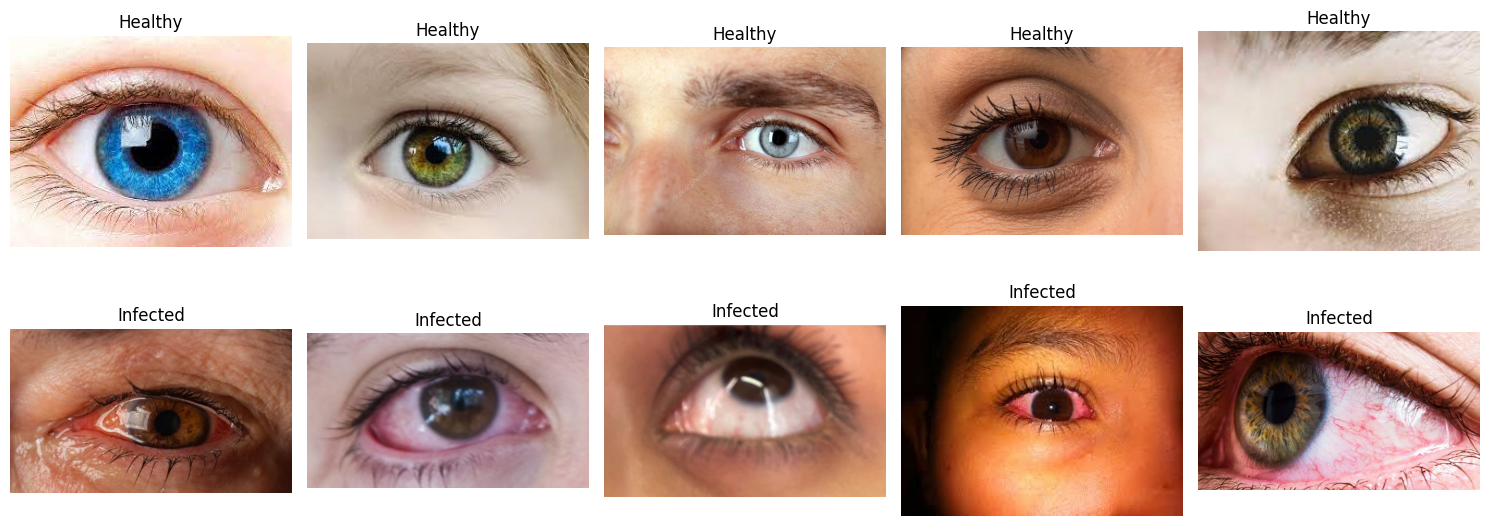

In [738]:
# makes a 2 row, 5 col grid of plots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, img_file in enumerate(healthy_imgs):
    img_rgb = load_image_convert(os.path.join(healthy_path, img_file))

    # shows the image
    axs[0, i].imshow(img_rgb)

    # makes title
    axs[0, i].set_title("Healthy")

    # no x/y ticks
    axs[0, i].axis('off')

for i, img_file in enumerate(infected_imgs):
    img_rgb = load_image_convert(os.path.join(infected_path, img_file))

    # shows the image
    axs[1, i].imshow(img_rgb)

    # makes title
    axs[1, i].set_title("Infected")

    # no x/y ticks
    axs[1, i].axis('off')

# remove overlap bw graphs
plt.tight_layout()

plt.show()

In [739]:
# loads a sample of each
healthy_sample = cv2.imread(os.path.join(healthy_path, healthy_imgs[0]))
infected_sample = cv2.imread(os.path.join(infected_path, infected_imgs[0]))

In [740]:
# inspect their shapes
print("Healthy image sample shape:", healthy_sample.shape)
print("Infected image sample shape:", infected_sample.shape)

Healthy image sample shape: (194, 259, 3)
Infected image sample shape: (648, 1111, 3)


In [741]:
# tqdm makes progress bar
from tqdm import tqdm

# new global list to track skipped files
skipped_files = []

def clean_resize_imgs(input_path, output_path, label):

    

    # lists all filed in input_path dir
    # wraps list in progress bar and adds description label
    for file in tqdm(os.listdir(input_path), desc=f"{label} images"):
        img_path = os.path.join(input_path, file)

        try:
            # loads the image
            img = cv2.imread(img_path)

            # skip corrupt (unreadable or greyscale imgs)
            # cv2.imread returns None if cannot read file
            # if not 3D (height, width, channels) (greyscale would be 2d)
            # checks len is exactly 3 which is RGB/BGR only
            # adds skipped file to list
            if img is None:
                skipped_files.append((file, "Unreadable (cv2.imread returned None)"))
                continue

            if len(img.shape) != 3 or img.shape[2] != 3:
                skipped_files.append((file, "Not a 3-channel RGB image"))
                continue

            # resize to standard size
            # can be changed later to optimize accuracy vs speed vs memory use
            try:
                resized_img = cv2.resize(img, (224, 224))
            except Exception as e:
                skipped_files.append((file, f"Resize error: {str(e)}"))
                continue

            # save to output folder
            # will overwrite existing files with same name without warning
            cv2.imwrite(os.path.join(output_path, file), resized_img)

        except Exception as e:
            print(f"Error processing {file}: {e}")



In [742]:
# clean healthy and infected imgs 
# write them to processed folder
clean_resize_imgs(healthy_path, processed_healthy_path, "Healthy")
clean_resize_imgs(infected_path, processed_infected_path, "Infected")

# save skipped file info in csv
if skipped_files:
    os.makedirs('../data/log', exist_ok=True)
    df_skipped = pd.DataFrame(skipped_files, columns=['filename', 'reason'])
    df_skipped.to_csv('../data/log/skipped_images_log.csv', index=False)
    print(f"Logged {len(skipped_files)} skipped files to ../data/log/skipped_images_log.csv")
else:
    print("No files were skipped.")

Infected images: 100%|██████████| 177/177 [00:00<00:00, 580.58it/s]

No files were skipped.


In [743]:
# count how many processed healthy + infected imgs
num_processed_healthy = len(os.listdir(processed_healthy_path))
num_processed_infected = len(os.listdir(processed_infected_path))

print(f"Number of processed healthy images: {num_processed_healthy}")
print(f"Number of processed infected images: {num_processed_infected}")

Number of processed healthy images: 181
Number of processed infected images: 177


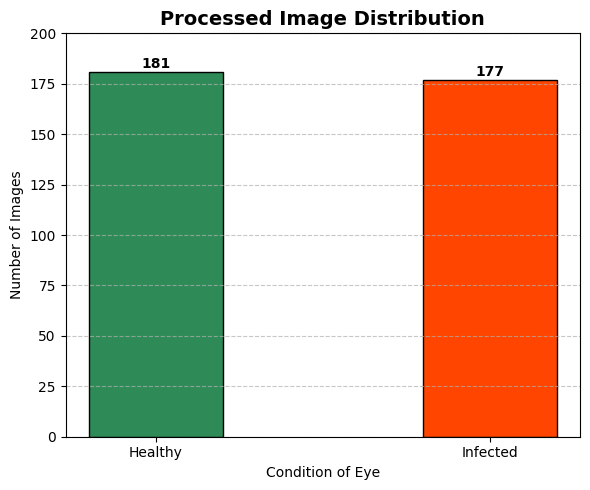

In [744]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["Healthy", "Infected"])
y = np.array([num_processed_healthy, num_processed_infected])

plt.figure(figsize=(6, 5))
plt.bar(x, y, color=['seagreen', 'orangered'], width=0.4, edgecolor='black')

# label values
for i, val in enumerate(y):
    plt.text(i, val + 2, str(val), ha='center', fontweight='bold')

plt.ylim(0, 200)
plt.xlabel("Condition of Eye")
plt.ylabel("Number of Images")
plt.title("Processed Image Distribution", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [745]:
def compute_fft_blur_score(image, size=60):

    # converts image to grayscale
    # fft works on intensity (brightness)
    # color adds unecessary complexity
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # gets height and width 
    (h, w) = gray.shape

    # calculates center pixel coordinates
    (cX, cY) = (int(w / 2.0), int(h / 2.0))

    # computes 2d fast fourier transform of img
    fft = np.fft.fft2(gray)

    # moves low freq components to the center of spectrum
    fftShift = np.fft.fftshift(fft)

    # removes  low freq (blurry info) from the center
    # size 60 means a 120x120 box
    # can be tweaked to see how sensitive sharpness becomes
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0

    # moves freqeuncies back to original quadrants
    fftShift = np.fft.ifftshift(fftShift)

    # inverses fft and now img doesn't have low freqs
    recon = np.fft.ifft2(fftShift)

    # computes log scaled magnitude of img
    magnitude = 20 * np.log(np.abs(recon) + 1e-8)  # avoid log(0)

    # averages high freq content in recon img
    mean_val = np.mean(magnitude)

    return mean_val

In [746]:
# checks if img is blurry based on fft score being < threshold
def check_blurry_fft(img, threshold):
    score = compute_fft_blur_score(img)
    return score < threshold, score

In [747]:
# creates list to store sharpness scores
sharpness_scores_healthy = []

# loops through all files of healthy eyes
for file in os.listdir(processed_healthy_path):

    # creates full path to img
    img_path = os.path.join(processed_healthy_path, file)

    # loads img as a np array
    img = cv2.imread(img_path)

    # skip img if it can't be loaded
    if img is None:
        continue

    # computes fft blur score
    score = compute_fft_blur_score(img)

    # adds score to list of sharpness scores
    sharpness_scores_healthy.append(score)

In [748]:
# does the same as above but for infected eyes
sharpness_scores_infected = []
for file in os.listdir(processed_infected_path):
    img_path = os.path.join(processed_infected_path, file)
    img = cv2.imread(img_path)
    if img is None:
        continue
    score = compute_fft_blur_score(img)
    sharpness_scores_infected.append(score)

In [749]:
# slices blurry tail off data
# 5% can be changed
dynamic_threshold_healthy = np.percentile(sharpness_scores_healthy, 5)
dynamic_threshold_infected = np.percentile(sharpness_scores_infected, 5)

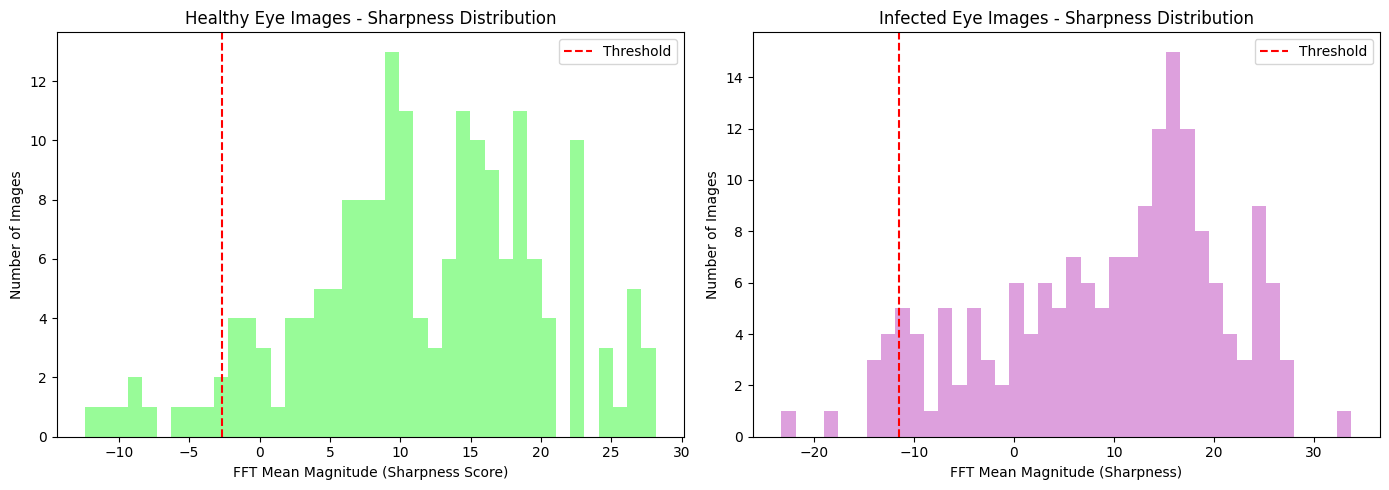

In [750]:

# shows the distribution of FFT-based sharpness scores
# for healthy and infected eyes  
# marks the threshold
# that separates the blurriest 5% from the rest
import matplotlib.pyplot as plt

# creates subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

# healthy eye histogram
axes[0].hist(sharpness_scores_healthy, bins=40, color='palegreen')
axes[0].axvline(x=dynamic_threshold_healthy, color='red', linestyle='--', label='Threshold')
axes[0].set_xlabel("FFT Mean Magnitude (Sharpness Score)")
axes[0].set_ylabel("Number of Images")
axes[0].set_title("Healthy Eye Images - Sharpness Distribution")
axes[0].legend()

# infected eye histogram
axes[1].hist(sharpness_scores_infected, bins=40, color='plum')
axes[1].axvline(x=dynamic_threshold_infected, color='red', linestyle='--', label='Threshold')
axes[1].set_xlabel("FFT Mean Magnitude (Sharpness)")
axes[1].set_ylabel("Number of Images")
axes[1].set_title("Infected Eye Images - Sharpness Distribution")
axes[1].legend()

# ensures no overlap
plt.tight_layout()

# saves plots
plt.savefig('../data/plots/fft_sharpness_histogram.png', dpi=300, bbox_inches='tight')

# displays plots
plt.show()

In [751]:
# defines paths for healthy and infected flagges (blurry imgs)
flagged_healthy_path = '../data/flagged/healthy_eye'
flagged_infected_path = '../data/flagged/infected_eye'

In [752]:
# MOVE flagged images BACK into processed
# import shutil

# for file in os.listdir(flagged_healthy_path):
#     shutil.move(os.path.join(flagged_healthy_path, file), os.path.join(processed_healthy_path, file))

# for file in os.listdir(flagged_infected_path):
#     shutil.move(os.path.join(flagged_infected_path, file), os.path.join(processed_infected_path, file))

In [753]:
# OPTIONAL: Clean flagged folders completely
# for file in os.listdir(flagged_healthy_path):
#    os.remove(os.path.join(flagged_healthy_path, file))

# for file in os.listdir(flagged_infected_path):
#     os.remove(os.path.join(flagged_infected_path, file))

In [754]:
# creates list for filenames and sharpness scores of blurry healthy
blurry_healthy = []

# loops through all files in processed healthy images
for file in os.listdir(processed_healthy_path):

    # created full path for blurry healthy images
    img_path = os.path.join(processed_healthy_path, file)

    # reads img
    img = cv2.imread(img_path)

    # skips img if it's corrupt
    if img is None:
        continue

    # check if it's blurry using healthy threshold
    is_blurry, score = check_blurry_fft(img, dynamic_threshold_healthy)

    # if blurry, add the filename and score to list
    if is_blurry:
        blurry_healthy.append((file, score))

In [755]:
# same thing as previous loop but for infected blurry eyes
blurry_infected = []
for file in os.listdir(processed_infected_path):
    img_path = os.path.join(processed_infected_path, file)
    img = cv2.imread(img_path)
    if img is None:
        continue
    is_blurry, score = check_blurry_fft(img, dynamic_threshold_infected)
    if is_blurry:
        blurry_infected.append((file, score))

In [756]:
import shutil # module used for moving files

# move each blurry healthy image from the processed folder to the flagged folder
# _ is placeholder for score as it's not being used here but blurry_healthy returns file and score
for file, _ in blurry_healthy:
    shutil.move(os.path.join(processed_healthy_path, file), # source path of blurry in processed folder
                os.path.join(flagged_healthy_path, file)) # destination path in flagged folder

# similar as above for infected 
for file, _ in blurry_infected:
    shutil.move(os.path.join(processed_infected_path, file), os.path.join(flagged_infected_path, file))

In [757]:
# prints number of images flagges and moved
print(f"Flagged and moved {len(blurry_healthy)} blurry healthy images.")
print(f"Flagged and moved {len(blurry_infected)} blurry infected images.")

Flagged and moved 9 blurry healthy images.
Flagged and moved 9 blurry infected images.


In [758]:
# prints number of images left in processed folder
print(f"Remaining healthy images in processed: {len(os.listdir(processed_healthy_path))}")
print(f"Remaining infected images in processed: {len(os.listdir(processed_infected_path))}")

Remaining healthy images in processed: 172
Remaining infected images in processed: 168


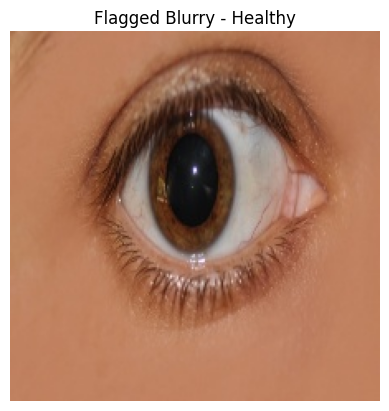

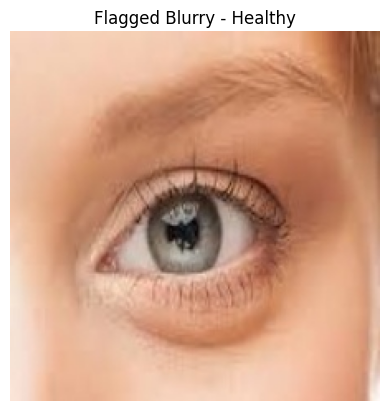

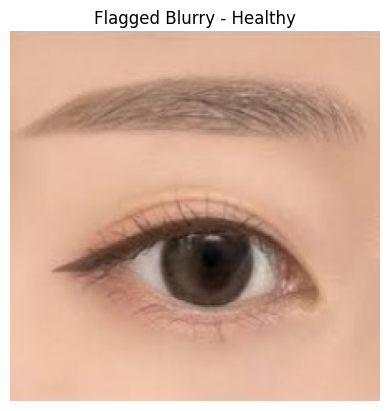

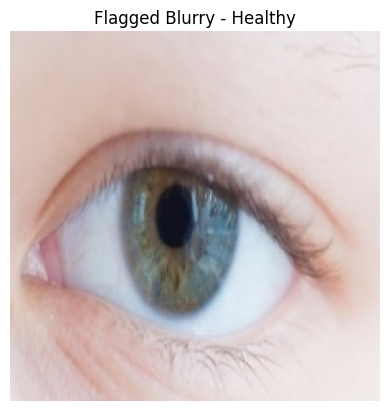

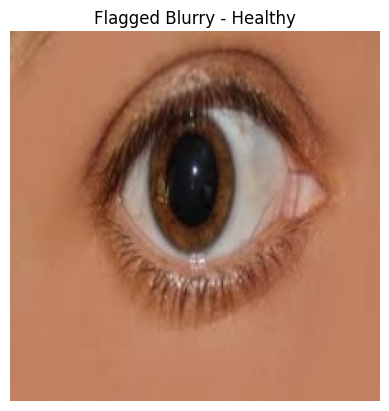

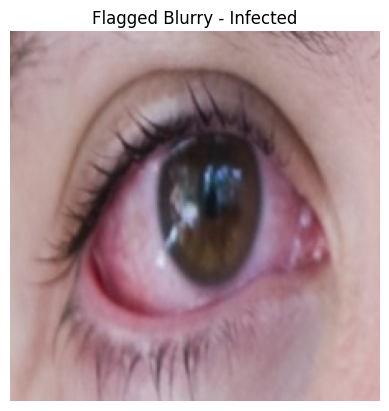

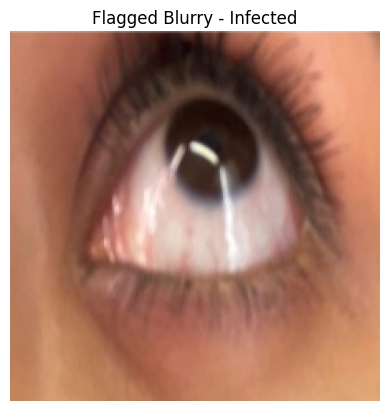

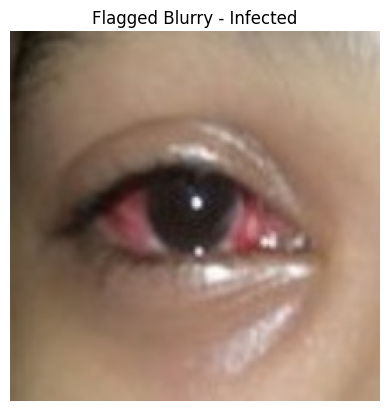

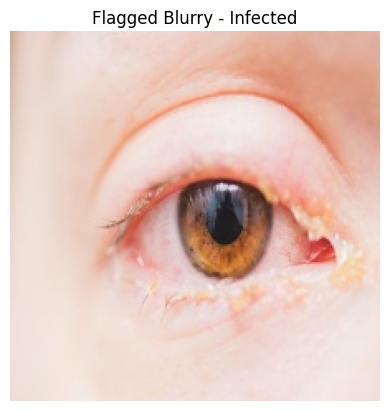

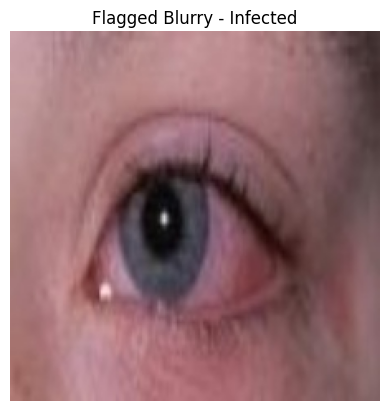

In [759]:
# view a few blurry healthy images
flagged_files_healthy = os.listdir(flagged_healthy_path)

# loop through the first 5 (or fewer) flagged healthy images
for file in flagged_files_healthy[:min(5, len(flagged_files_healthy))]:

    # load and convert image to correct RGB
    img = load_image_convert(os.path.join(flagged_healthy_path, file))

    # loads image into plot
    plt.imshow(img)

    plt.title("Flagged Blurry - Healthy")
    plt.axis('off')

    # renders image
    plt.show()


# same for infected images
flagged_files_infected = os.listdir(flagged_infected_path)
for file in flagged_files_infected[:min(5, len(flagged_files_infected))]:
    img = load_image_convert(os.path.join(flagged_infected_path, file))
    plt.imshow(img)
    plt.title("Flagged Blurry - Infected")
    plt.axis('off')
    plt.show()

In [764]:
import pandas as pd

# collect file and label
data = []

for file in os.listdir(processed_healthy_path):
    data.append({"filename": file, "label" : "healthy"})

for file in os.listdir(processed_infected_path):
    data.append({"filename": file, "label" : "infected"})

# convert to dataframe
df = pd.DataFrame(data)

# save as csv
csv_output_path = '../data/log/image_labels.csv'
df.to_csv(csv_output_path, index=False)

print(f"Label-to-filename mapping saved as CSV at {csv_output_path}")

Label-to-filename mapping saved as CSV at ../data/log/image_labels.csv


In [763]:
os.makedirs('../data/log', exist_ok=True)

# healthy blurry images log
df_blurry_healthy = pd.DataFrame(blurry_healthy, columns=['filename', 'sharpness_score'])
df_blurry_healthy['threshold_used'] = dynamic_threshold_healthy
df_blurry_healthy.to_csv('../data/log/blurry_healthy_log.csv', index=False)

# infected blurry images log
df_blurry_infected = pd.DataFrame(blurry_infected, columns=['filename', 'sharpness_score'])
df_blurry_infected['threshold_used'] = dynamic_threshold_infected
df_blurry_infected.to_csv('../data/log/blurry_infected_log.csv', index=False)

print("Blurry image logs saved to '../data/log/'")

Blurry image logs saved to '../data/log/'
